In [1]:
%load_ext autoreload
%autoreload 2

import os

import matplotlib as mpl
import pandas as pd
from matplotlib import animation

from sync.elastic import ELASTIC
from tools.animator import Animator
from tools.sportec_data import SportecData

pd.set_option('display.width', 250)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 30)

%matplotlib inline
mpl.rcParams['animation.embed_limit'] = 100

### Data Preparation

This tutorial demonstrates how to apply ELASTIC to the [Sportec Open DFL Dataset (Bassek et al., 2025)](https://www.nature.com/articles/s41597-025-04505-y). It consists of event and tracking data from seven matches of German Bundesliga's first and second divisions, and can be downloaded from [this link](https://springernature.figshare.com/articles/dataset/An_integrated_dataset_of_spatiotemporal_and_event_data_in_elite_soccer/28196177).
| match_id | home                  | away                   |
|:--------:|-----------------------|------------------------|
| J03WMX   | 1. FC Köln            | FC Bayern München      |
| J03WN1   | VfL Bochum 1848       | Bayer 04 Leverkusen    |
| J03WPY   | Fortuna Düsseldorf    | 1. FC Nürnberg         |
| J03WOH   | Fortuna Düsseldorf    | SSV Jahn Regensburg    |
| J03WQQ   | Fortuna Düsseldorf    | FC St. Pauli           |
| J03WOY   | Fortuna Düsseldorf    | F.C. Hansa Rostock     |
| J03WR9   | Fortuna Düsseldorf    | 1. FC Kaiserslautern   |

After downloading the data, place the XML files by type in the following directories:
- Match information: `data/sportec/metadata`
- Event data: `data/sportec/event`
- Tracking data: `data/sportec/tracking`

Then, choose the match ID you want to synchronize and run the following code.

In [2]:
# It can take about one or two minutes to parse tracking data using kloppy
root_dir = "/home/work/data/dataset/MHL/dfl-confidential/raw"
# root_dir = "/home/work/data/MHL/value-pausa/data"
match_id = "DFL-MAT-J03YE3"
match = SportecData(root_dir, match_id)
match.lineup.head()

Loading the tracking data...


Transforming the tracking data coordinates...


,team_id,team_name,home_away,player_id,uniform_number,object_id,player_name,starting,playing_position,captain
0,DFL-CLU-000010,FC Augsburg,away,DFL-OBJ-0028CO,1,away_1,Finn Dahmen,True,GK,False
1,DFL-CLU-000010,FC Augsburg,away,DFL-OBJ-002GJF,2,away_2,Robert Gumny,False,RB,False
2,DFL-CLU-000010,FC Augsburg,away,DFL-OBJ-002G1W,3,away_3,Mads Pedersen,True,LB,False
3,DFL-CLU-000010,FC Augsburg,away,DFL-OBJ-J01SEG,7,away_7,Dion Beljo,False,RCF,False
4,DFL-CLU-000010,FC Augsburg,away,DFL-OBJ-0027UO,8,away_8,E. Rexhbecaj,True,RDM,False


We categorize events based on [SPADL (Decroos et al., 2019)](https://arxiv.org/abs/1802.07127). The following code converts Sportec event data into the SPADL format and prepares it as a proper input for ELASTIC. (For details on the required input formats, see `sync/schema.py`.)

In [3]:
input_events = match.format_events_for_syncer()
input_events

,period_id,utc_timestamp,player_id,spadl_type,start_x,start_y,success
0,1,2023-08-27 15:30:01.210,home_11,pass,52.50,34.00,True
1,1,2023-08-27 15:30:04.494,home_26,pass,17.43,30.49,False
2,1,2023-08-27 15:30:15.521,away_30,pass,72.24,29.29,True
3,1,2023-08-27 15:30:23.731,away_1,pass,101.79,34.70,True
4,1,2023-08-27 15:30:25.167,away_19,pass,98.89,14.24,True
...,...,...,...,...,...,...,...
1334,2,2023-08-27 17:23:21.563,home_6,dispossessed,80.75,44.23,True
1335,2,2023-08-27 17:23:23.029,away_21,tackle,80.75,43.33,True
1336,2,2023-08-27 17:23:26.142,home_38,pass,80.82,39.94,True
1337,2,2023-08-27 17:23:29.871,home_9,shot,88.12,30.26,False


Similarly, tracking data can also be converted into the ELASTIC input format.

In [4]:
input_tracking = match.format_tracking_for_syncer()
input_tracking

,frame_id,period_id,timestamp,utc_timestamp,player_id,ball,x,y,z,speed,accel_s,accel_v
0,10000,1,0.00,2023-08-27 15:30:01.210,home_26,False,17.69,36.49,NaN,1.087024,3.756194,4.953252
1,10001,1,0.04,2023-08-27 15:30:01.250,home_26,False,17.72,36.46,NaN,1.087024,3.756194,4.953252
2,10002,1,0.08,2023-08-27 15:30:01.290,home_26,False,17.75,36.41,NaN,1.233752,3.739648,4.710825
3,10003,1,0.12,2023-08-27 15:30:01.330,home_26,False,17.77,36.37,NaN,1.384838,3.701132,4.475481
4,10004,1,0.16,2023-08-27 15:30:01.370,home_26,False,17.79,36.31,NaN,1.535744,3.640648,4.245815
...,...,...,...,...,...,...,...,...,...,...,...,...
2132371,173422,2,2936.88,2023-08-27 17:23:30.890,None,True,104.43,12.70,0.96,7.772842,-14.366339,14.381616
2132372,173423,2,2936.92,2023-08-27 17:23:30.930,None,True,104.60,12.45,0.52,7.129023,-22.364748,22.364950
2132373,173424,2,2936.96,2023-08-27 17:23:30.970,None,True,104.78,12.19,0.05,6.240388,-25.945553,25.939806
2132374,173425,2,2937.00,2023-08-27 17:23:31.010,None,True,104.97,12.04,0.12,5.175088,-28.246719,28.234005


### Data Sychronization

By running the following code, you can synchronize the event and tracking data with these four stages:
1. Kick-off synchronization
2. Major event synchronization (for pass-like, incoming, and set-piece events)
3. Receive detection (for pass-like and set-piece events)
4. Minor event synchronization (for `tackle`, `foul`, `bad_touch`, `take_on`, and `dispossessed`)

<p align="center">
  <img src="docs/sync_stages.png" width="500" />
</p>

In [5]:
syncer = ELASTIC(input_events, input_tracking)
syncer.run()

Post-syncing minor events: 100%|██████████| 113/113 [00:03<00:00, 35.44it/s]


As a result, the synchronized timstamps are stored in `frame_id` and `synced_ts` columns. The detected end timestamps of pass-like and set-piece events are stroed in `receive_frame_id` and `receive_ts` columns.

In [11]:
syncer.events

,period_id,utc_timestamp,player_id,spadl_type,start_x,start_y,success,next_player_id,next_type,frame_id,receiver_id,receive_frame_id,synced_ts,receive_ts
0,1,2023-08-27 15:30:01.210,home_11,pass,52.50,34.00,True,home_26,pass,10000.0,home_26,10060.0,00:00.00,00:02.40
1,1,2023-08-27 15:30:04.494,home_26,pass,17.43,30.49,False,away_30,pass,10105.0,away_30,10190.0,00:04.20,00:07.60
2,1,2023-08-27 15:30:15.521,away_30,pass,72.24,29.29,True,away_1,pass,10190.0,away_23,10440.0,00:07.60,00:17.60
3,1,2023-08-27 15:30:23.731,away_1,pass,101.79,34.70,True,away_19,pass,10524.0,away_19,10555.0,00:20.96,00:22.20
4,1,2023-08-27 15:30:25.167,away_19,pass,98.89,14.24,True,away_1,pass,10588.0,away_1,10629.0,00:23.52,00:25.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1334,2,2023-08-27 17:23:21.643,home_6,dispossessed,80.75,44.23,True,away_21,tackle,NaN,None,NaN,NaN,NaN
1335,2,2023-08-27 17:23:23.109,away_21,tackle,80.75,43.33,True,home_38,pass,NaN,None,NaN,NaN,NaN
1336,2,2023-08-27 17:23:26.222,home_38,pass,80.82,39.94,True,home_9,shot,NaN,None,NaN,NaN,NaN
1337,2,2023-08-27 17:23:29.951,home_9,shot,88.12,30.26,False,away_19,shot_block,NaN,None,NaN,NaN,NaN


### Animating Events and Trajectories 

To check the result of synchronization, you can generate an animation of player and ball trajectories with raw/synchronized events by running the following code. Feel free to choose which segment to visualize by modifying `start_frame` and `end_frame`!

In [12]:
# By default, this code generates and animation for the given match's first minute
start_frame = 10000
end_frame = 11500

merged_data = SportecData.merge_synced_events_and_tracking(syncer.events, match.tracking, match.fps, ffill=True)
segment_data = merged_data.set_index("frame_id").loc[start_frame:end_frame].copy()
animator = Animator({"main": segment_data}, show_events=True)
anim = animator.run()

writer = animation.FFMpegWriter(fps=match.fps)
os.makedirs("animations", exist_ok=True)
anim_path = f"animations/sportec_{match_id}_{start_frame}-{end_frame}.mp4"
anim.save(anim_path, writer=writer)

### Visualizing Individual Windows

To check how ELASTIC decided the best timestamp for each event, you can plot features for the given event.

Event 1: pass by home_26
Matched frame: 10105
Matched time: P1-00:04.20


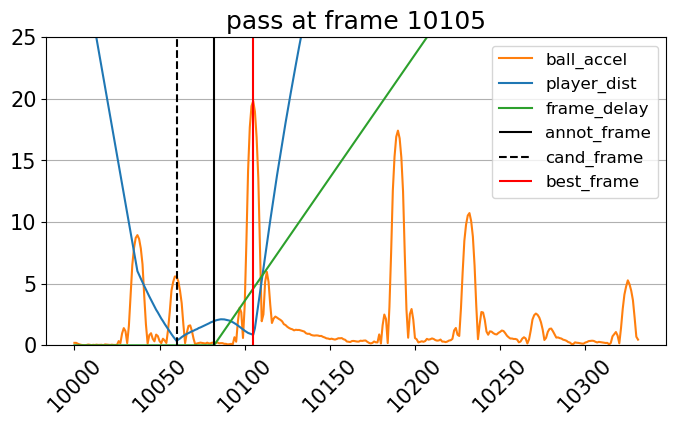

,frame_delay,player_speed,player_accel,ball_accel,ball_height,player_dist,kick_dist,score
frame_id,,,,,,,,
10060,0,1.321759,1.095102,27.929973,0.02,0.348281,2.111516,82.655234
10105,23,2.169998,8.035298,99.113588,0.02,0.851645,57.168890,88.302954


In [13]:
# pass-like event
syncer.plot_window_features(1)

Event 27: pass by home_6
Matched frame: 12993
Matched time: P1-01:59.72


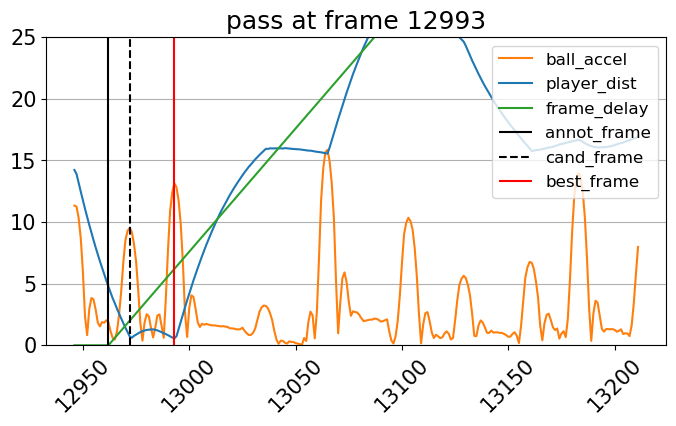

,frame_delay,player_speed,player_accel,ball_accel,ball_height,player_dist,kick_dist,score
frame_id,,,,,,,,
12972,10,0.529002,2.269196,47.643528,0.02,0.611882,1.292517,74.363565
12993,31,3.386251,1.277043,65.714282,0.03,0.558032,30.186230,89.149731


In [14]:
# incoming event
syncer.plot_window_features(27)

Current event: pass by home_11
Next event: pass by home_26

Detected receiver: home_26
Receiving frame: 10060.0
Receiving time: P1-00:02.40


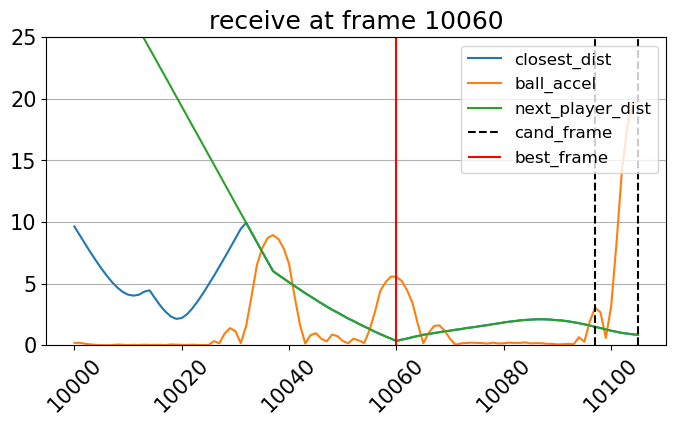

,ball_height,ball_accel,next_player_dist,closest_id,closest_dist,kick_dist,score
frame_id,,,,,,,
10060,0.02,27.929973,0.348281,home_26,0.348281,34.823062,94.195308
10097,0.02,15.973662,1.182244,home_26,1.182244,0.611383,53.319930
10105,0.02,99.113588,0.851645,home_26,0.851645,0.648488,64.048348


In [15]:
# receive
syncer.receive_det.plot_window_features(0)

Event 178: tackle by home_2
Matched frame: 24335
Matched time: P1-09:33.40


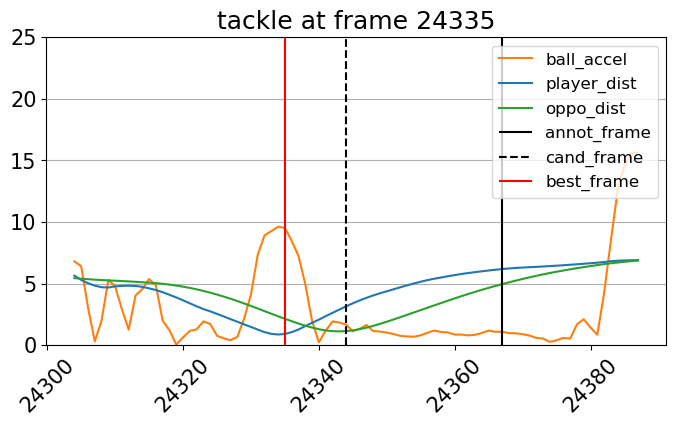

,frame_delay,player_speed,player_accel,ball_accel,ball_height,player_dist,oppo_id,oppo_rel_x,oppo_rel_y,oppo_dist,kick_dist,score
frame_id,,,,,,,,,,,,
24335,0,2.646399,4.593431,48.121773,0.02,0.874458,away_38,-2.14,0.19,1.589972,3.158787,76.205613
24344,2,3.622078,3.328546,9.661285,0.02,2.364335,away_38,-0.53,1.01,1.127187,6.908222,66.064475


In [40]:
# minor event
syncer.plot_window_features(178)